In [11]:
import pandas as pd

temp = pd.read_excel('Prices.xlsx')

In [12]:
temp.head()

,时间(年-月),供给(元/㎡),关注(元/㎡),价值(元/㎡),供给(万元),关注(万元),供给(套),供给(㎡),关注(㎡),供给(年),关注(年)
0,2019-03-01,65253,62880,34250,753.5,792.6,57090,114.12,124.92,57,64
1,2019-02-01,65473,58102,34408,747.3,631.0,37322,114.05,101.50,57,66
2,2019-01-01,64663,57958,33774,730.2,594.3,42247,113.87,100.42,57,49
3,2018-12-01,63405,55919,33193,753.9,681.5,42976,116.33,119.57,57,55
4,2018-11-01,62298,72462,32983,745.4,931.0,42078,117.05,122.35,57,64


In [9]:
# 使用LSTM对PM2.5进行预测，根据8个特征维度预测PM指数 pollution
import pandas as pd
from pandas import read_csv, DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from itertools import chain
import warnings
warnings.filterwarnings("ignore")


"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # 输入序列 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # 拼接到一起
    agg = concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_predict, test_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict], c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], c='r')
    plt.legend()
    plt.show()


In [7]:
# 数据加载
dataset = pd.read_excel('Prices.xlsx', header=0, index_col=0)
values = dataset.values
print(values)
print(values.shape)

[[65253 62880 34250 753.5 792.6 57090 114.12 124.92 57 64]
 [65473 58102 34408 747.3 631.0 37322 114.05 101.5 57 66]
 [64663 57958 33774 730.2 594.3 42247 113.87 100.42 57 49]
 [63405 55919 33193 753.9 681.5 42976 116.33 119.57 57 55]
 [62298 72462 32983 745.4 931.0 42078 117.05 122.35 57 64]
 [62193 81697 33720 733.1 1108.7 47607 115.42 130.53 55 66]
 [61921 62822 33733 735.1 810.6 48101 115.88 121.64 55 58]
 [63441 65957 34153 789.7 879.7 54498 120.46 121.5 56 59]
 [63711 63864 33239 765.4 838.6 43432 119.2 118.82 58 57]
 [64051 60900 32386 771.6 800.0 63327 118.35 118.69 59 54]
 [64773 60977 32079 783.2 792.6 69864 118.02 116.14 61 58]
 [63093 57613 31758 760.8 759.6 68579 116.7 116.55 60 56]
 [63419 61155 30880 754.0 825.4 82056 115.28 119.92 62 62]
 [63993 57420 30275 802.8 742.6 36377 118.1 115.49 63 63]
 [62871 60171 31323 776.9 840.3 43146 119.33 122.47 60 64]
 [62241 62736 31317 761.1 857.2 58399 119.75 120.72 60 66]
 [65347 61304 28266 781.7 796.0 69558 117.6 115.88 69 68]
 [

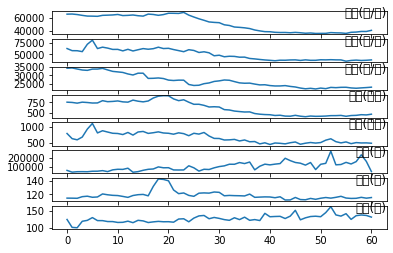

In [10]:
# 设置需要可视化的列表
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# 数据探索EDA
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [16]:
# 将分类特征wnd_dir 进行标签编码
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# 设置数据类型均为flast32
# values = values.astype('float32')
#pd.DataFrame(values).to_csv('values.csv')
print(values)

# 0-1规范化
scaler = MinMaxScaler(feature_range=(3,4))
scaled = scaler.fit_transform(values)
print(scaled)

[[65253 62880 34250 753.5 792.6 57090 114.12 124.92 57 64]
 [65473 58102 34408 747.3 631.0 37322 114.05 101.5 57 66]
 [64663 57958 33774 730.2 594.3 42247 113.87 100.42 57 49]
 [63405 55919 33193 753.9 681.5 42976 116.33 119.57 57 55]
 [62298 72462 32983 745.4 931.0 42078 117.05 122.35 57 64]
 [62193 81697 33720 733.1 1108.7 47607 115.42 130.53 55 66]
 [61921 62822 33733 735.1 810.6 48101 115.88 121.64 55 58]
 [63441 65957 34153 789.7 879.7 54498 120.46 121.5 56 59]
 [63711 63864 33239 765.4 838.6 43432 119.2 118.82 58 57]
 [64051 60900 32386 771.6 800.0 63327 118.35 118.69 59 54]
 [64773 60977 32079 783.2 792.6 69864 118.02 116.14 61 58]
 [63093 57613 31758 760.8 759.6 68579 116.7 116.55 60 56]
 [63419 61155 30880 754.0 825.4 82056 115.28 119.92 62 62]
 [63993 57420 30275 802.8 742.6 36377 118.1 115.49 63 63]
 [62871 60171 31323 776.9 840.3 43146 119.33 122.47 60 64]
 [62241 62736 31317 761.1 857.2 58399 119.75 120.72 60 66]
 [65347 61304 28266 781.7 796.0 69558 117.6 115.88 69 68]
 [

ValueError: could not convert string to float: '--'

In [19]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
reframed.to_csv('reframed-1.csv')

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
...          ...        ...        ...        ...        ...        ...   
43795   0.010060   0.264706   0.278689   0.763638   0.333333   0.385730   
43796   0.008048   0.250000   0.278689   0.781818   0.333333   0.395659   
43797   0.010060   0.264706   0.262295   0.781818   0.333333   0.405588   
43798   0.010060   0.264706   0.262295   0.781818   0.333333   0.413996   
43799   0.008048   0.264706   0.245902   0.781818   0.333333   0.420866   

       var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1       0.000000  

In [ ]:
# 去掉不需要预测的列，即var2(t)    var3(t)    var4(t)    var5(t)    var6(t)    var7(t)    var8(t)
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# reframed.to_csv('reframed-2.csv')
#print(reframed.head())

In [20]:
# 训练集80%，测试集20%
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# :-1表示从0到数组最后一位，-1表示数组最后一位
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)

# 转换成3D格式 [样本数, 时间步, 特征数]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X)
#print(test_X)

(35039, 15)


15
Train on 35039 samples, validate on 8760 samples
Epoch 1/10
 - 2s - loss: 0.0086 - val_loss: 0.0072
Epoch 2/10
 - 2s - loss: 0.0064 - val_loss: 0.0044
Epoch 3/10
 - 2s - loss: 0.0055 - val_loss: 0.0094
Epoch 4/10
 - 2s - loss: 0.0049 - val_loss: 0.0053
Epoch 5/10
 - 2s - loss: 0.0044 - val_loss: 0.0035
Epoch 6/10
 - 2s - loss: 0.0038 - val_loss: 0.0044
Epoch 7/10
 - 2s - loss: 0.0038 - val_loss: 0.0040
Epoch 8/10
 - 2s - loss: 0.0038 - val_loss: 0.0065
Epoch 9/10
 - 2s - loss: 0.0039 - val_loss: 0.0049
Epoch 10/10
 - 2s - loss: 0.0035 - val_loss: 0.0034


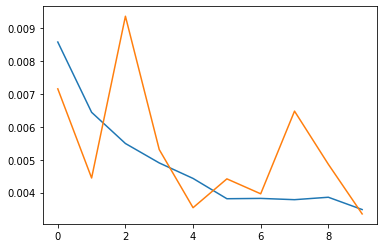

No handles with labels found to put in legend.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
_________________________________________________________________
None


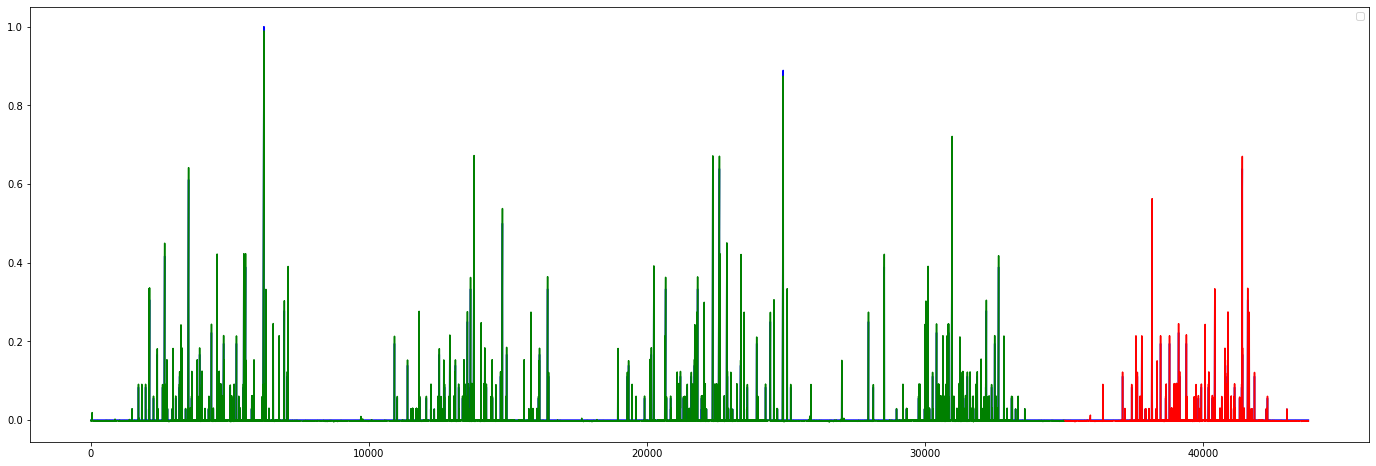

In [21]:
# 设置网络模型
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
print(test_X.shape[2])
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 模型训练
result = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 模型预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# 绘制训练损失和测试损失
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.show()
print(model.summary())
# 绘制预测结果与实际结果对比
plot_img(values, train_predict, test_predict)
